At this stage in our exploration fo the synaptic diversity datasets, it seems that the main reasons we have had such difficulty with finding clusters is that there is simply too many outliers within the dataset. The method used to detect the synapses by our collaborator led to a large number if false positives. We must find and discard these false positives.

In [1]:
#This code ingests the provided dataset, throws out columns 5 and 6, and labels the columns.

loadData <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#The data is composed of 144 columns, with each 6 consecutive columns corresponding to 1 of 24 markers. Apparently column 5 and 6 of the data are unnecessary and should be thrown out.
	#List of fluorescent markers used
	markers <- c('Synap_1', 'Synap_2', 'VGlut1_1', 'VGlut1_2', 'VGlut2', 'VGlut3', 'PSD', 'Glur2', 'NDAR1', 'NR2B', 'GAD', 'VGAT', 'PV',
	'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'Tubuli', 'DAPI')
	
	#What columns 1-4 for each of the florescent markers coorespond to.
	labels <- c('Int_Bright','Local_Bright','Dist_COM','MOI')
	
	#Generate labels for each column
	col_labels <- c() 
	
	for (i in 1:length(markers)){
		for (j in 1:length(labels)){
			col_labels[(i - 1) * length(labels) + j] = paste(markers[i],"_",labels[j],sep = "")
		}
	}
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data <- fread("synapsinR_7thA.tif.Pivots.txt.2011Features.txt")

	#Convert to dataframe
	data <- as.data.frame(data)

	#Remove columns 5 and 6 corresponding to each fluorescent marker
	good_ones <- c(1:dim(data)[2])
	dim(good_ones) <- c(6,dim(data)[2] / 6)
	good_ones <- good_ones[1:4,]
	dim(good_ones) <- c(4 * dim(good_ones)[2],1)
	data_cleaned <- data[,good_ones]
	
	#Label data
	colnames(data_cleaned) <- col_labels
	
	return(data_cleaned)
}

We load our dataset:

In [2]:
data <- loadData()

Loading required package: data.table
Warning message:
: package 'data.table' was built under R version 3.1.3

Read 1119299 rows and 144 (of 144) columns from 1.817 GB file in 00:05:56


In [3]:
#Subsamples 10000 rows from the original data set for easier analysis

subsampleRows <- function(data,samples = 10000,seed = 42){
	#Subsample some number of rows for further analysis. Set seed for reproducibility.
	set.seed(seed);rand_rows = sample(1:dim(data)[1],samples)
	subsample <- data[rand_rows,]
	return(subsample)
}

We subsample 10,000 rows for further analysis:

In [4]:
subsample <- subsampleRows(data)

In [5]:
#Scales each column of the input data frame by converting to Z scores and optionally log scaling the data

scaleData <- function(data,center = TRUE,scale = TRUE, log = TRUE){
	data_scaled <- scale(data, center = center,scale = scale)
    if(log){
        norm_0_1 <- function(x) {(x - min(x, na.rm=TRUE))/(max(x,na.rm=TRUE) - min(x, na.rm=TRUE))}
        data_scaled <- log(norm_0_1(data_scaled) + 1) / log(10)
    }
	return(data_scaled)
}

We z-score scale and log z-score scale our data for further analysis:

In [6]:
subsample <- scaleData(subsample, log = FALSE)
subsample_s <- scaleData(subsample)

In [7]:
#For labeling

library(gplots)
library(colorRamps)

channel <- c('Synap_1','Synap_2','VGlut1_t1','VGlut1_t2','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI')
channel.type <- c('ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','in.pre.small','other',
                  'ex.post','other','other','ex.post','none','none')
nchannel <- length(channel)
nfeat <- ncol(data) / nchannel
fchannel <- as.numeric(factor(channel.type,
    levels= c("ex.pre","ex.post","in.pre","in.post","in.pre.small","other","none")
    ))
ford <- order(fchannel)
Syncol <- c("#197300","#5ed155","#990000","#cc0000","#ff9933","mediumblue","gold")
ccol <- Syncol[fchannel]


fname <- as.vector(sapply(channel,function(x) paste0(x,paste0("F",0:5))))
names(subsample) <- fname
names(subsample_s) <- fname
fcol <- rep(ccol, each=6)
mycol <- colorpanel(100, "purple", "black", "green")
mycol2 <- matlab.like(nchannel)

Warning message:
: package 'gplots' was built under R version 3.1.3
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
: package 'colorRamps' was built under R version 3.1.3

We conduct the rest of the analysis only on f0:

In [8]:
#Use only f0

f0 <- seq(1,ncol(data),by=nfeat)
featF0s <- subset(subsample, select=f0)
flog <- subset(subsample_s, select=f0)

We first visualize the marginals:

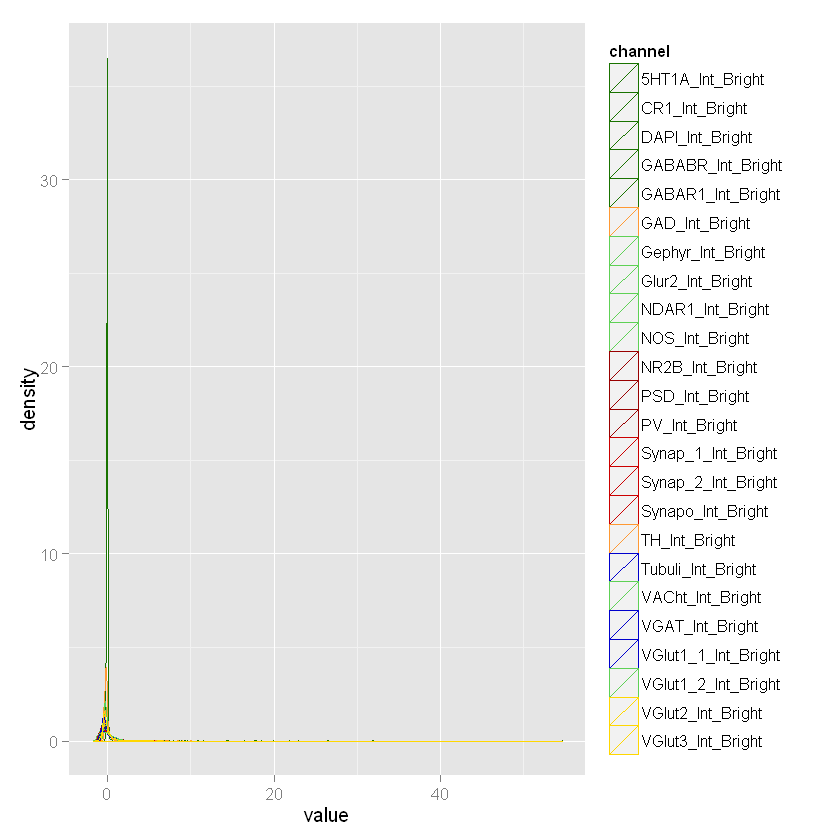

In [9]:
#Visualize the marginals without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s)

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol) +
    #scale_x_log10(limits=c(1e+03,1e+06), breaks=c(1e+03,5e+03,1e+04,5e+04,1e+05,5e+05,1e+06))+
    geom_density(aes(group=channel, colour=channel))

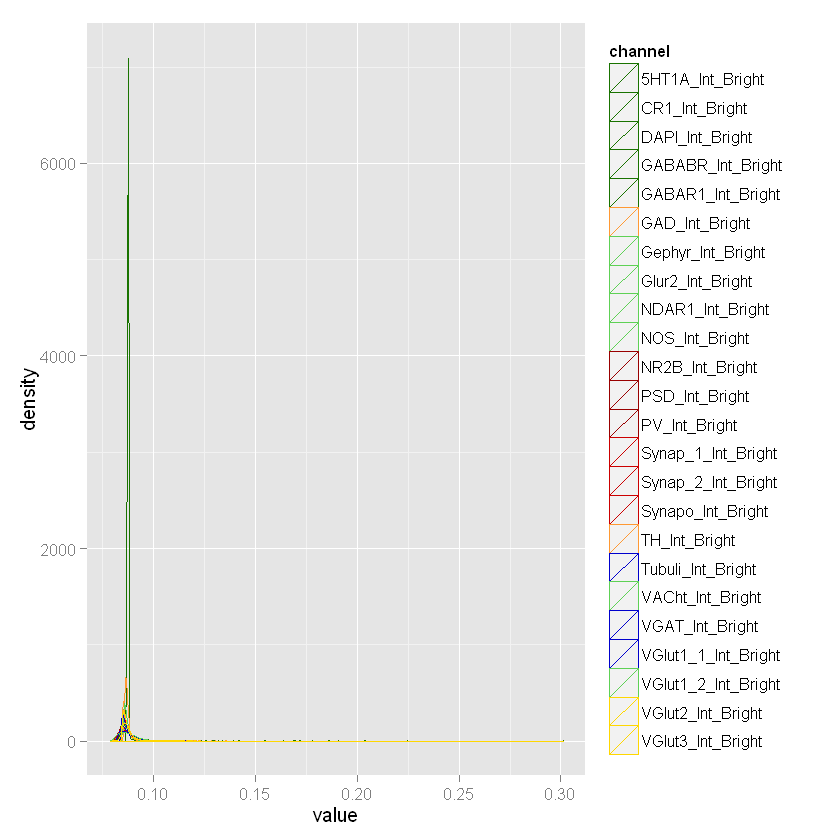

In [10]:
#Visualize the marginals with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog)

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol) +
    #scale_x_log10(limits=c(1e+03,1e+06), breaks=c(1e+03,5e+03,1e+04,5e+04,1e+05,5e+05,1e+06))+
    geom_density(aes(group=channel, colour=channel))

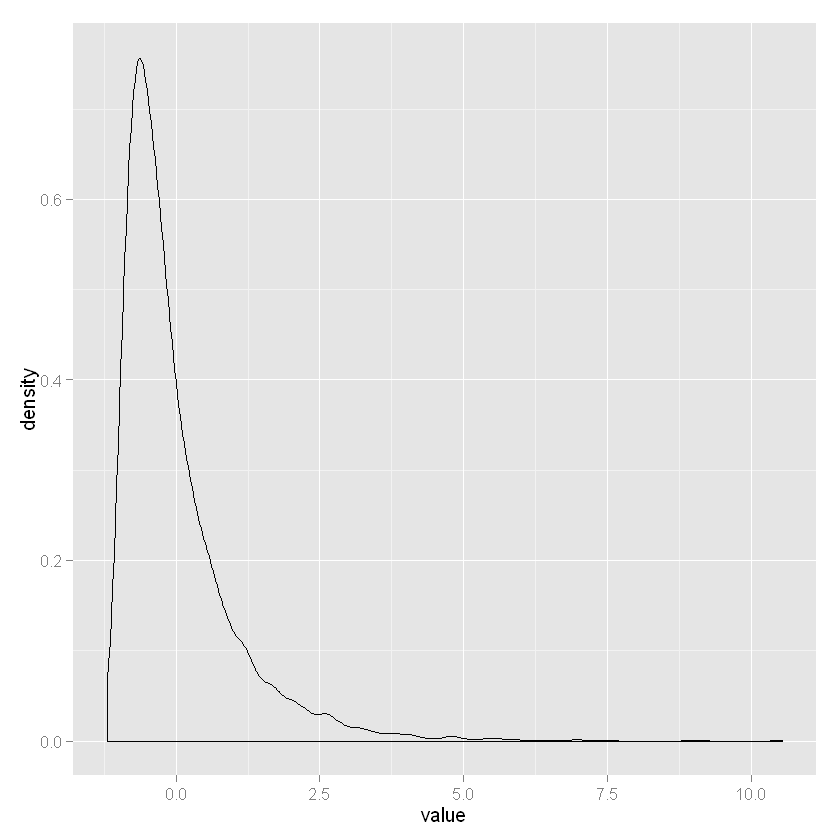

In [11]:
#Visualize only the synapsin marginal without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

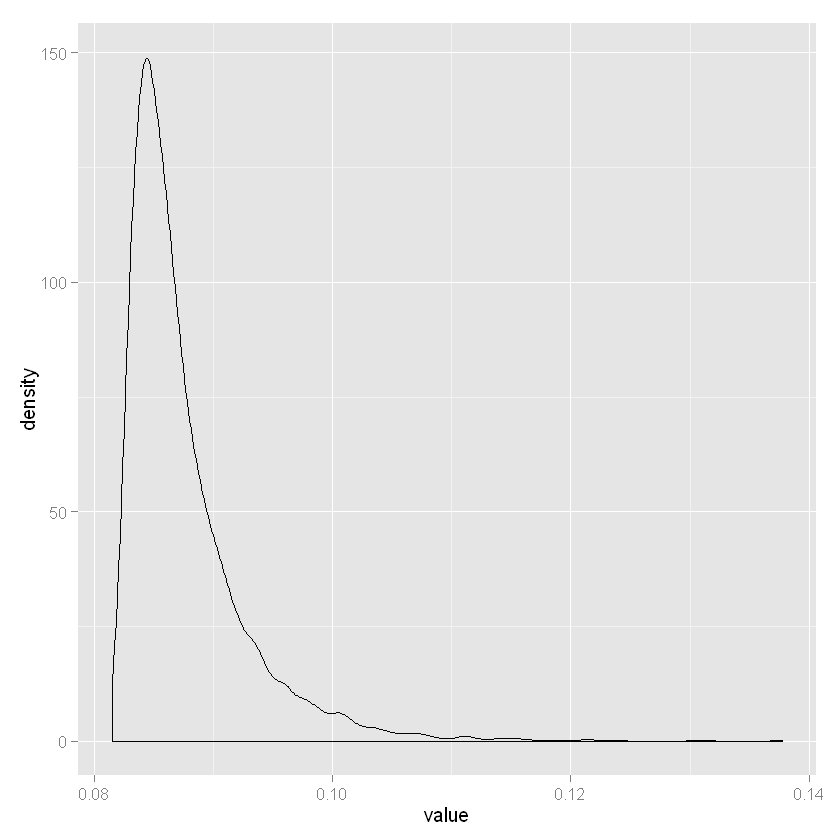

In [12]:
#Visualize only the synapsin marginal with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

It seems reasonable that the "synapses" with a low synapsin fluorescence are actually outliers. We will attempt to get rid of them in 3 main ways: 
(1) Remove any synapses with high DAPI fluorescence
(2) Remove any synapses with high tubuli fluorescence
(3) Remove the remaining synapses with low Synapsin fluorescence

We start with DAPI:

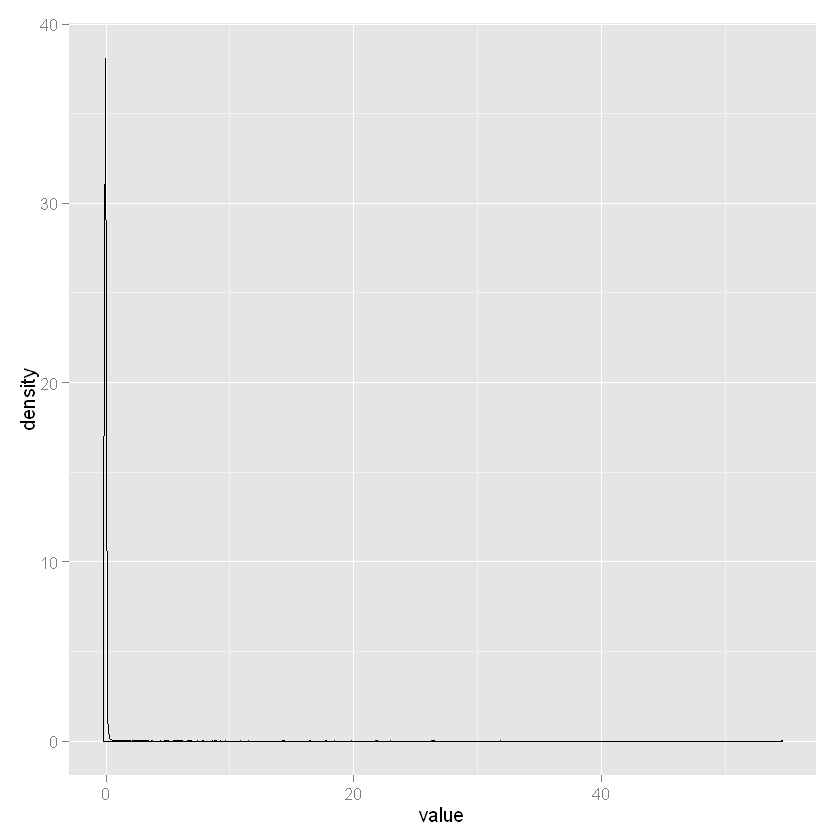

In [13]:
#Visualize only the DAPI marginal without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s[,24])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

Remove the synapses with high DAPI fluorescence:

In [14]:
keep_index <- which(featF0s[,24] < 0.1)
reject_index <- which(featF0s[,24] > 0.1) 
featF0s_rmdapi <-featF0s[keep_index,]
flog_rmdapi <- flog[keep_index,]
length(reject_index)

[1] 219

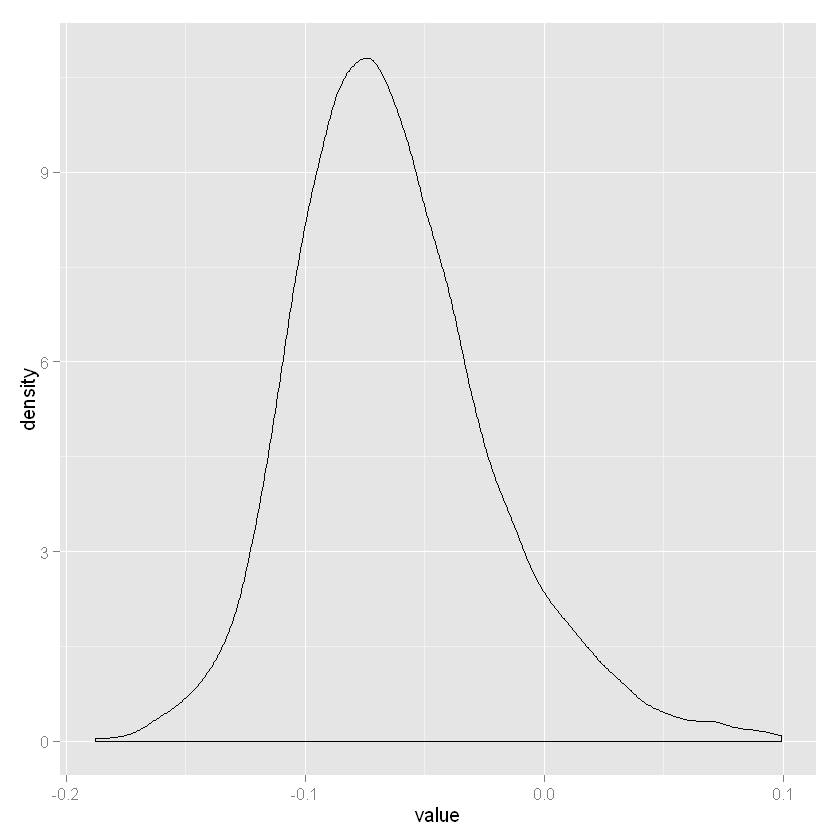

In [15]:
#Check the DAPI marginal
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s_rmdapi[,24])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

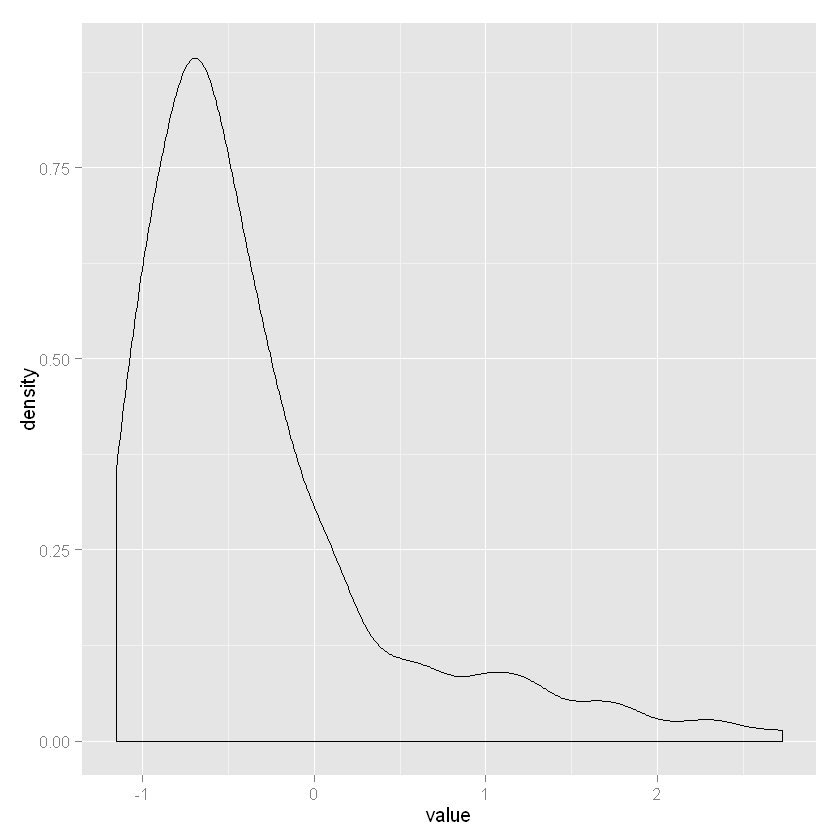

In [16]:
#Visualize the synapsin marginal of the rejected synapses (due to DAPI)
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s[reject_index,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

Next we remove the synapses wit high tubuli fluorescence:

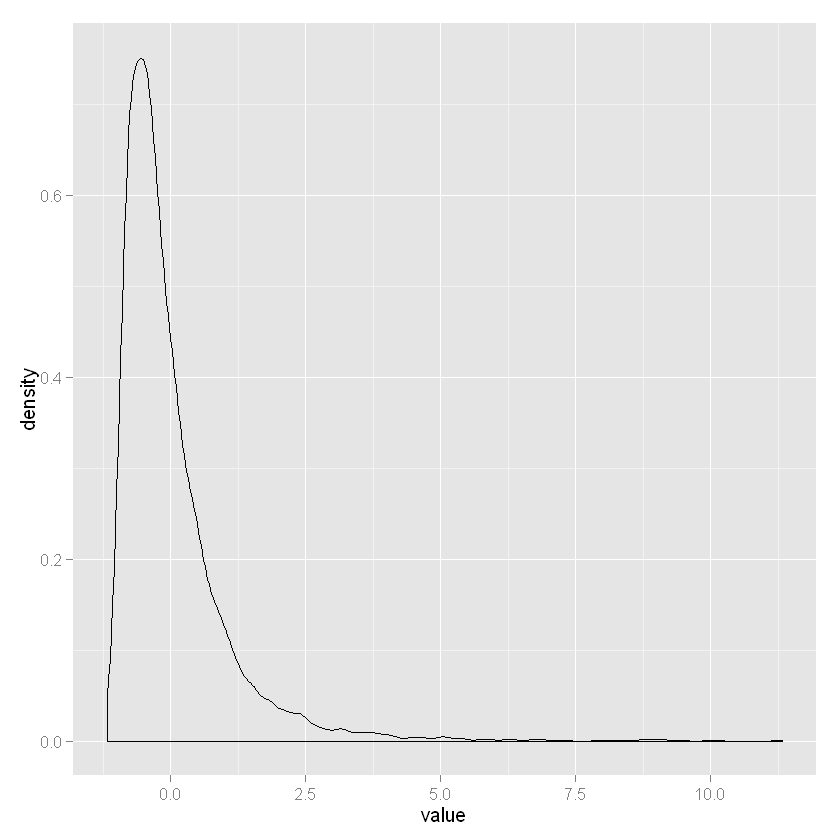

In [17]:
#Visualize only the tubuli marginal without log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s_rmdapi[,23])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

In [18]:
keep_index <- which(featF0s_rmdapi[,23] < 0.1)
reject_index <- which(featF0s_rmdapi[,23] > 0.1) 
featF0s_rmdt <-featF0s_rmdapi[keep_index,]
flog_rmdt <- flog_rmdapi[keep_index,]
length(reject_index)
length(keep_index)

[1] 3079

[1] 6702

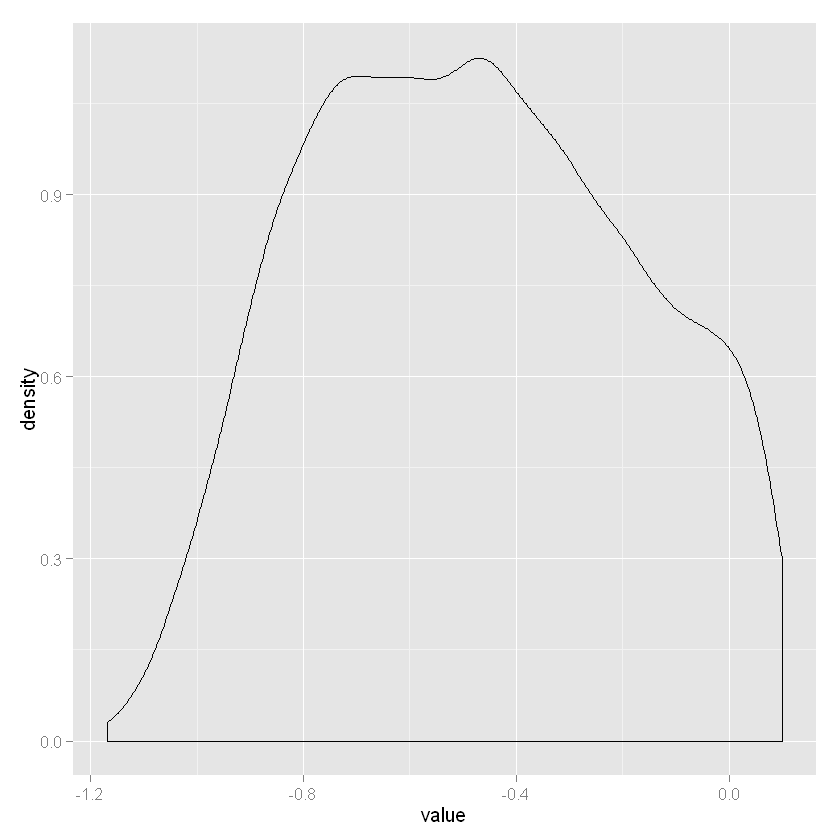

In [19]:
#Check the tubuli marginal
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s_rmdt[,23])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

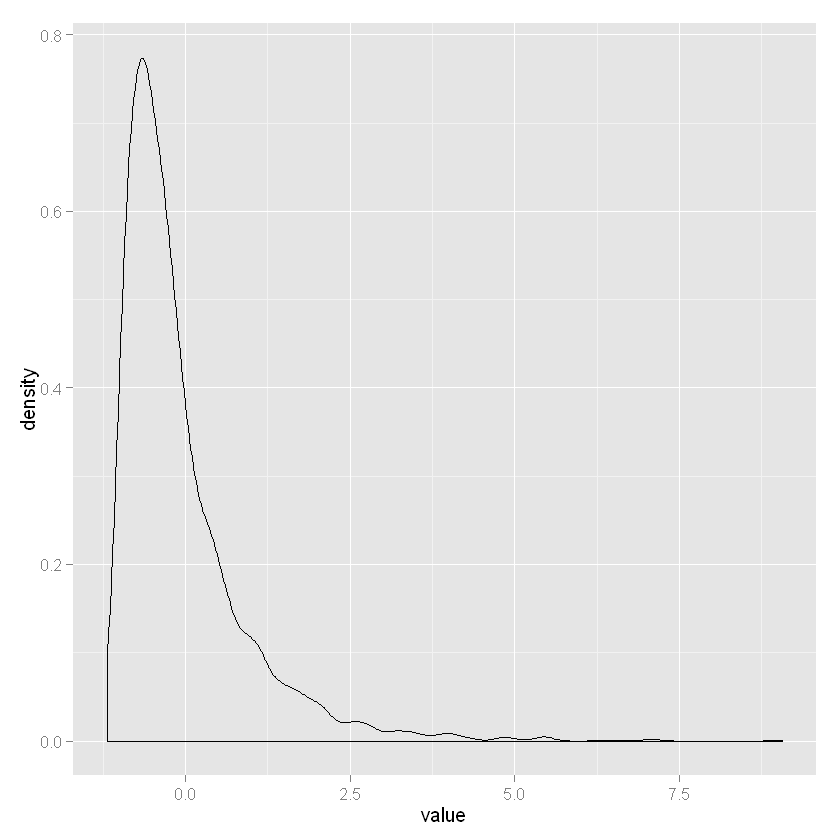

In [20]:
#Visualize the synapsin marginal of the rejected synapses (due to tubuli)
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s_rmdapi[reject_index,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

Let's see what is left:

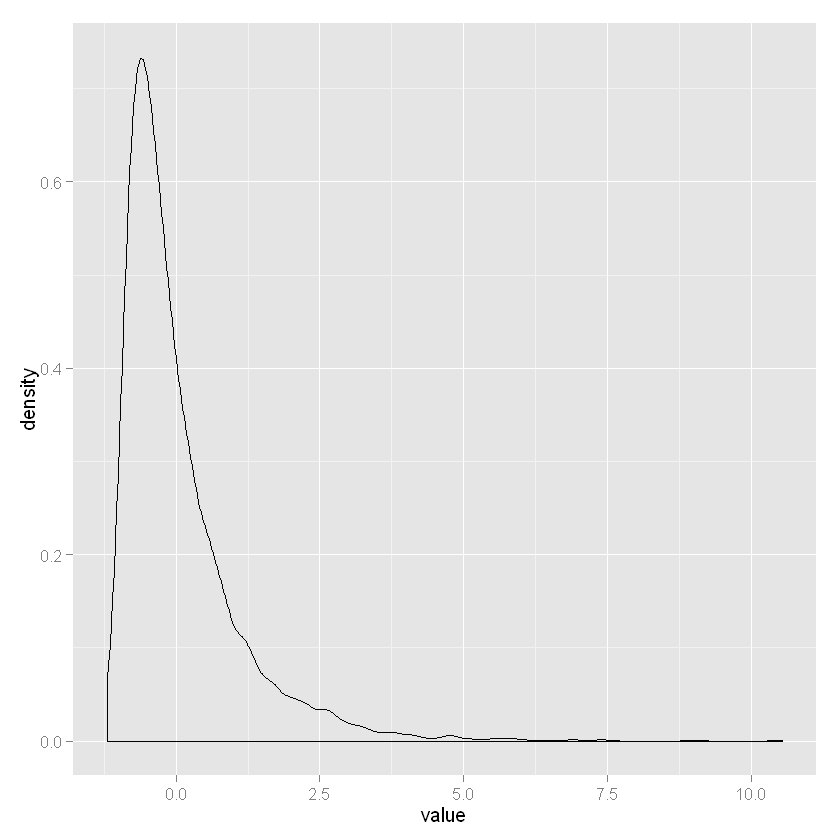

In [21]:
#Visualize the synapsin marginal without log scaling of the remaining data
library(reshape)
library(ggplot2)

featKDE <- as.matrix(featF0s_rmdt[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

Ok, now let us remove synapses with low Synapsin fluorescence:

In [22]:
keep_index <- which(featF0s_rmdt[,1] > 1)
reject_index <- which(featF0s_rmdt[,1] < 1) 
featF0s_rmdtc <-featF0s_rmdt[keep_index,]
flog_rmdtc <- flog_rmdt[keep_index,]
length(keep_index)

[1] 887

Let's visualize the marginals again:

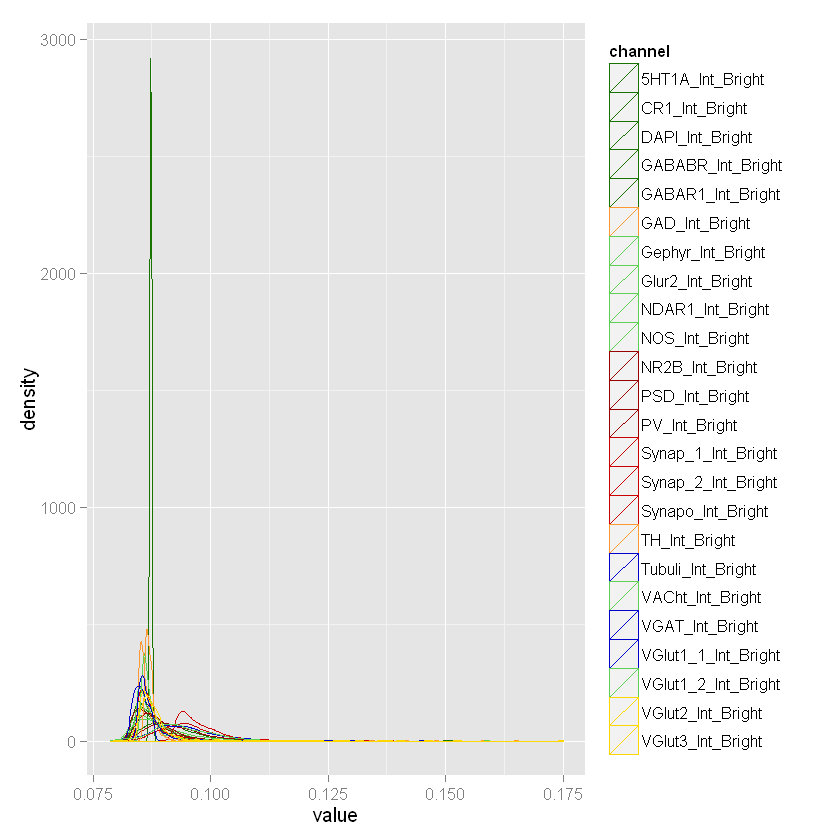

In [23]:
df <- melt(as.matrix(flog_rmdtc))
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol) +
    geom_density(aes(group=channel, colour=channel))

In [24]:
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)

K1 <- 12  ## Set the upperbound for k-means.

## Run kmeans on the scaled data
kvecF0 <- foreach(i = 1:K1) %dopar% {
    set.seed(2^13 - 1)
    kmeans(featF0s_rmdtc,centers=i)
}

## Run kmeans on the 
## log scale transformed data
kvecflog <- foreach(i = 1:K1) %dopar% {
    set.seed(2^13 - 1)
    kmeans(flog_rmdtc,centers=i)
}

Warning message:
: package 'doParallel' was built under R version 3.1.3Loading required package: foreach
Warning message:
: package 'foreach' was built under R version 3.1.3Loading required package: iterators
Warning message:
: package 'iterators' was built under R version 3.1.3Loading required package: parallel


We now try to cluster the markers:

 [1] "gold"       "#990000"    "gold"       "#cc0000"    "#990000"   
 [6] "#990000"    "#ff9933"    "#cc0000"    "mediumblue" "#ff9933"   
[11] "#5ed155"    "#5ed155"    "#197300"    "#5ed155"    "mediumblue"
[16] "#5ed155"    "mediumblue" "#5ed155"    "#cc0000"    "#5ed155"   
[21] "#197300"    "#197300"    "#197300"    "#197300"   


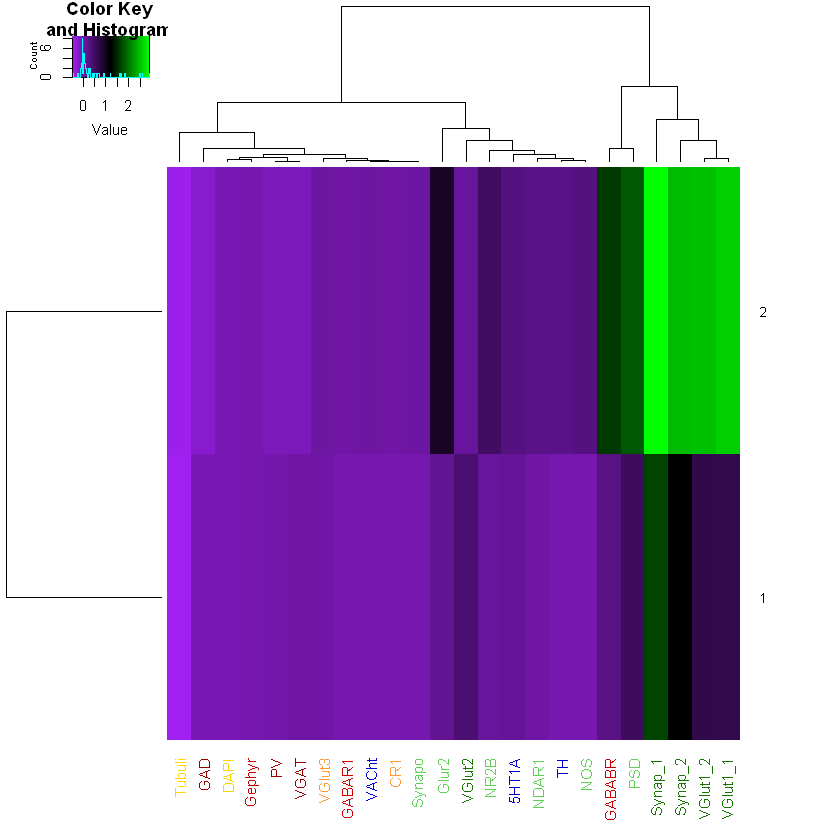

In [25]:
## Formatting data for heatmap
feat2 <- aggregate(featF0s_rmdtc,by=list(lab=kvecF0[[2]]$cluster),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol,colCol=ccol,cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

 [1] "#cc0000"    "#5ed155"    "#197300"    "#197300"    "#197300"   
 [6] "#197300"    "#5ed155"    "#197300"    "#5ed155"    "mediumblue"
[11] "#5ed155"    "mediumblue" "#5ed155"    "gold"       "#990000"   
[16] "gold"       "#cc0000"    "#990000"    "#990000"    "#ff9933"   
[21] "#cc0000"    "mediumblue" "#ff9933"    "#5ed155"   


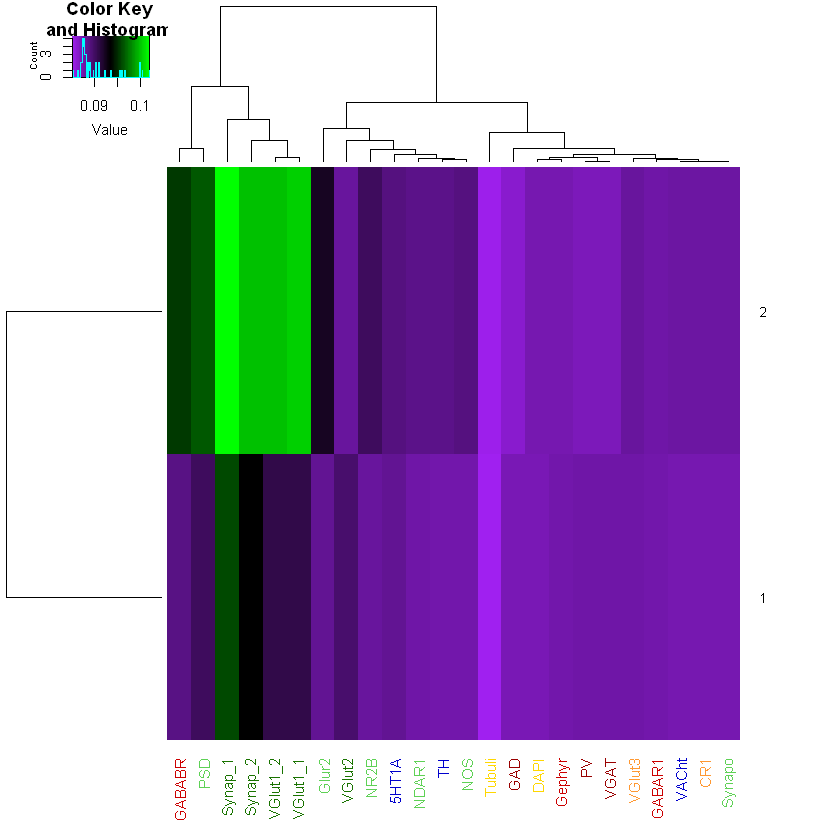

In [26]:
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc,by=list(lab=kvecflog[[2]]$cluster),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol,colCol=ccol,cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

It seems like they cluster pretty well. Now let us try to cluster the synapses.

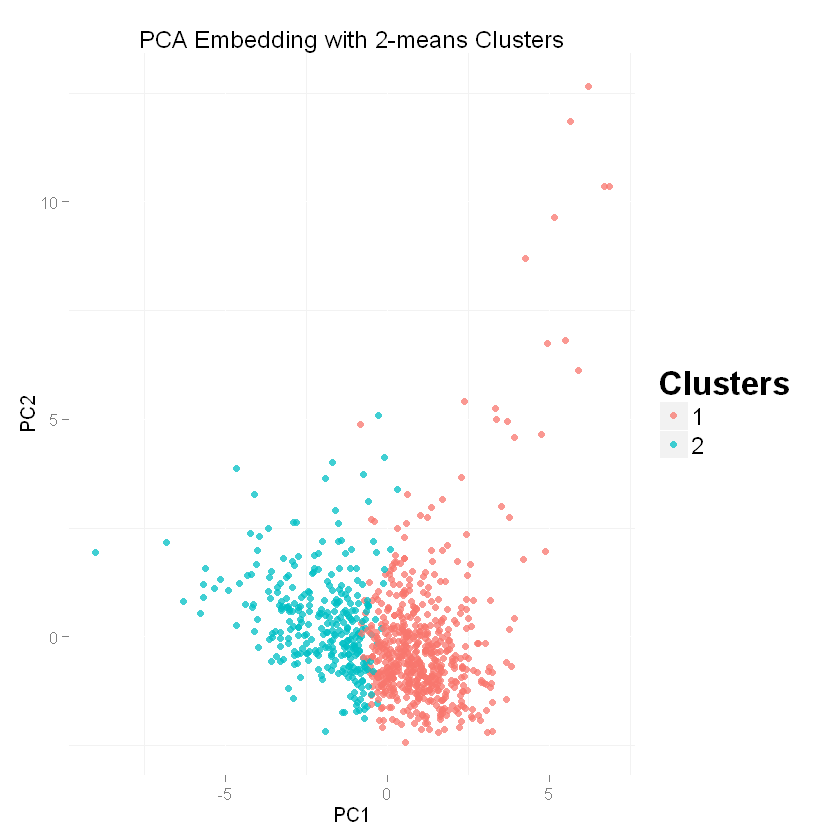

In [27]:
#PCA all data down to 2 dimensions
fit <- prcomp(x = flog_rmdtc,center = TRUE,scale = TRUE)
data_embed <- fit$x[,1:2];
embed_graph <- as.data.frame(data_embed);

clust_graph <- as.data.frame(cbind(data_embed,kvecF0[[2]]$cluster))
colnames(clust_graph)[3] <- 'Clusters'
clust_graph[,3] <- as.factor(clust_graph[,3])

p1 <- ggplot(clust_graph,aes(PC1,PC2,color = Clusters)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding with 2-means Clusters')

p1

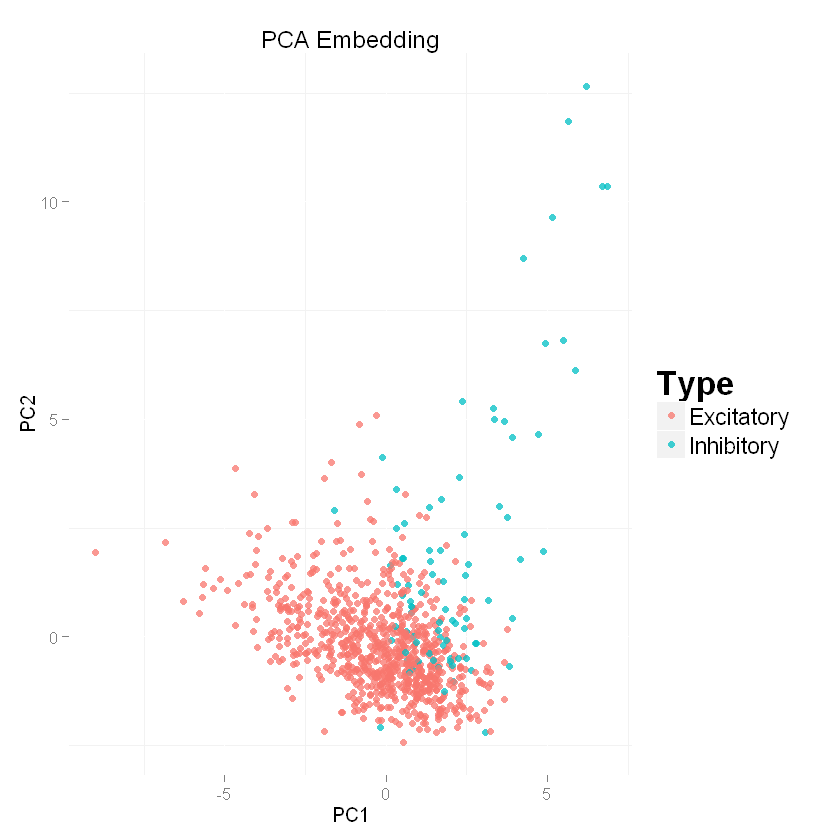

In [28]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- ex_mean > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'

clust_graph <- as.data.frame(data_embed)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p2 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p2

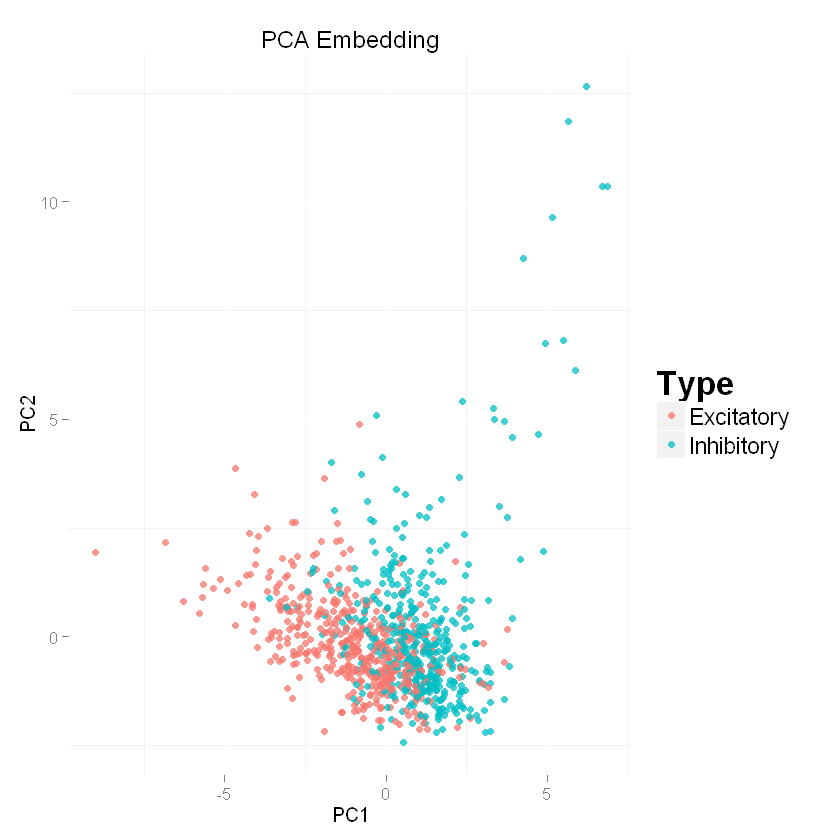

In [29]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.965 * ex_mean) > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'

clust_graph <- as.data.frame(data_embed)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p3 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p3

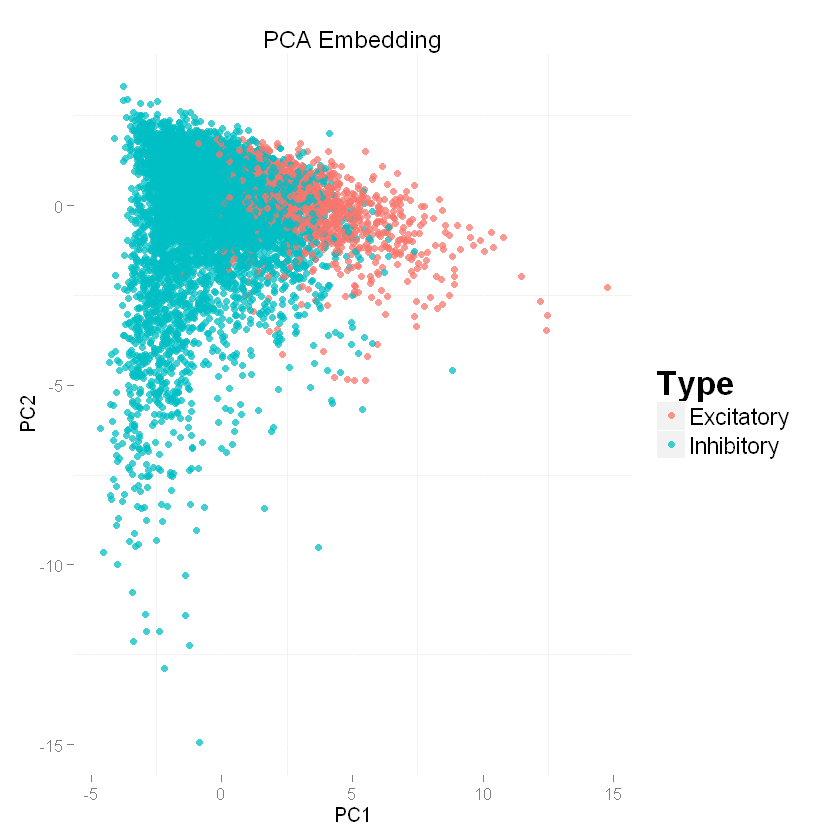

In [30]:
ex_mean <- rowMeans(flog[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.965 * ex_mean) > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'

fit_old <- prcomp(x = flog,center = TRUE,scale = TRUE)
data_embed_old <- fit_old$x[,1:2];

clust_graph <- as.data.frame(data_embed_old)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p4 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p4

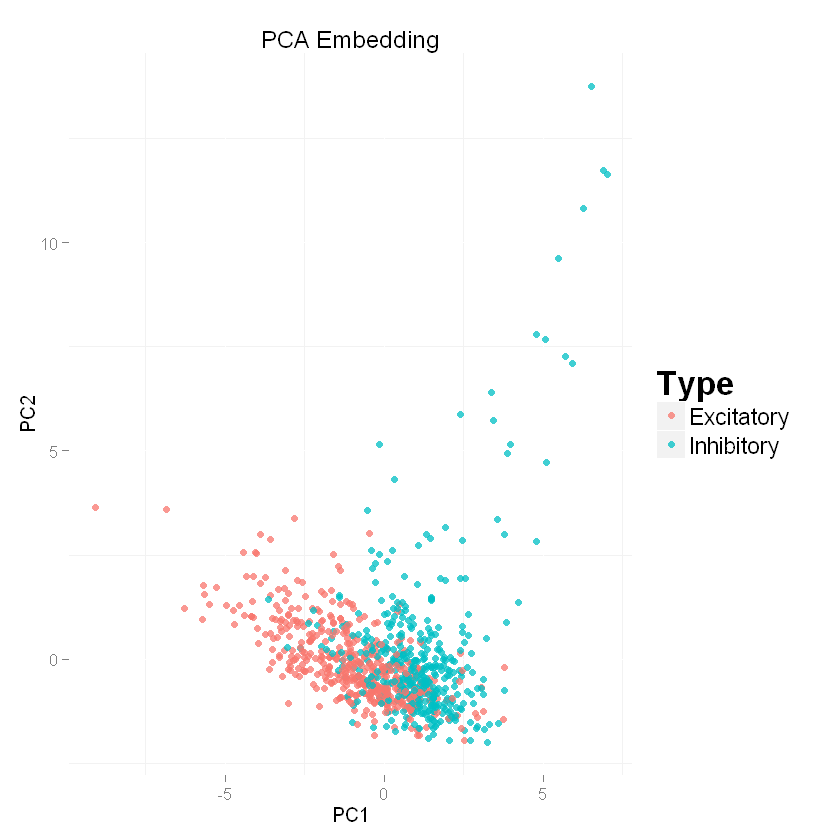

In [31]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.965 * ex_mean) > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'

fit_new <- prcomp(x = flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23,6,11,12,13,14,15,16,17)],center = TRUE,scale = TRUE)
data_embed_new <- fit_new$x[,1:2];

clust_graph <- as.data.frame(data_embed_new)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p5 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p5

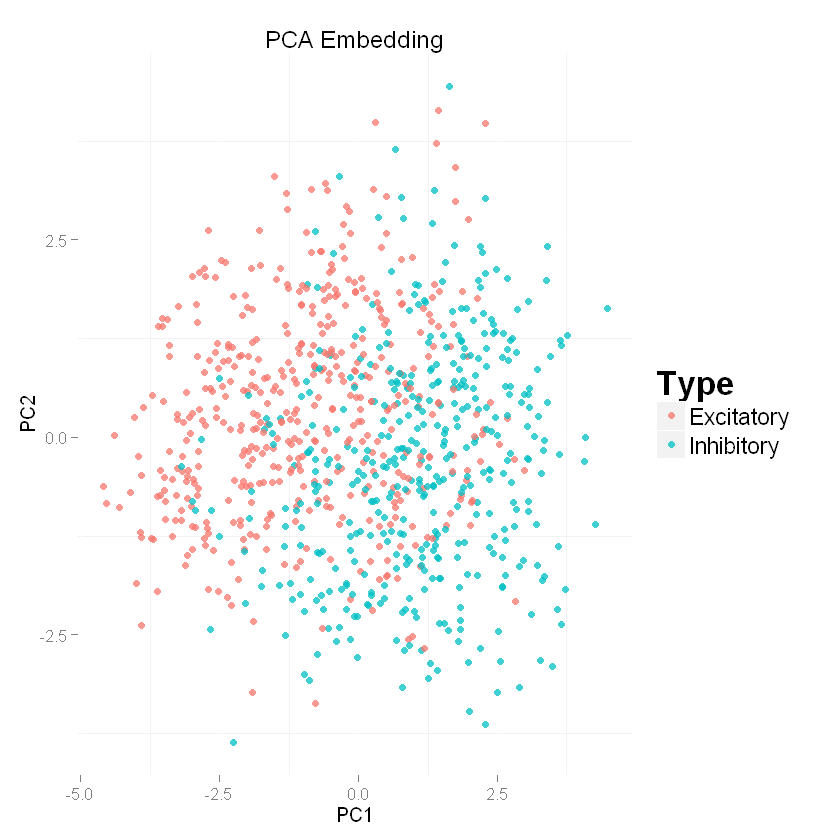

In [32]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.965 * ex_mean) > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'

fit_new <- prcomp(x = apply(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23,6,11,12,13,14,15,16,17)],2,rank),center = TRUE,scale = TRUE)
data_embed_new <- fit_new$x[,1:2];

clust_graph <- as.data.frame(data_embed_new)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p6 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p6

Warning message:
: package 'tsne' was built under R version 3.1.3sigma summary: Min. : 0.3857 |1st Qu. : 0.4721 |Median : 0.5078 |Mean : 0.5242 |3rd Qu. : 0.5533 |Max. : 1.196 |
Epoch: Iteration #100 error is: 19.6581268476284
Epoch: Iteration #200 error is: 1.88005931915078
Epoch: Iteration #300 error is: 1.79244706637746
Epoch: Iteration #400 error is: 1.76403275850993
Epoch: Iteration #500 error is: 1.75175399056126
Epoch: Iteration #600 error is: 1.74583526815216
Epoch: Iteration #700 error is: 1.74375568545314
Epoch: Iteration #800 error is: 1.74866496133083
Epoch: Iteration #900 error is: 1.74857805825208
Epoch: Iteration #1000 error is: 1.74865318178714


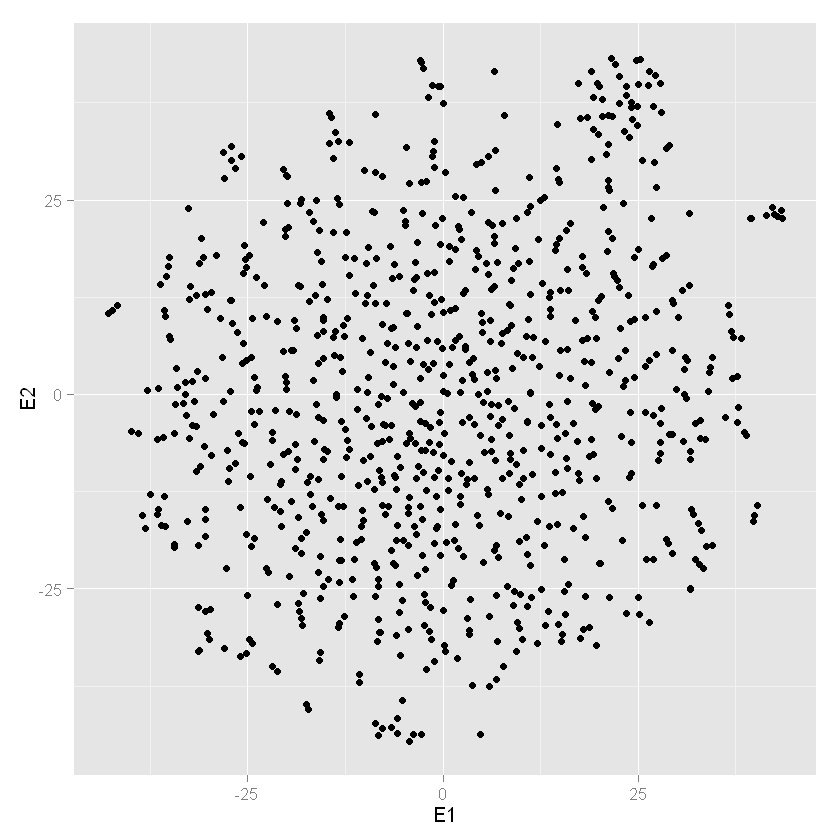

In [33]:
library(tsne)

tsne_data <- tsne(flog_rmdtc, perplexity=30,epoch = 100)
tsne_embed <- tsne_data
colnames(tsne_embed) <- c('E1','E2')

df <- as.data.frame(cbind(flog_rmdtc,tsne_embed))

p7 <- ggplot(df, aes(E1, E2)) + geom_point()

p7

sigma summary: Min. : 0.3572 |1st Qu. : 0.467 |Median : 0.5013 |Mean : 0.5021 |3rd Qu. : 0.5349 |Max. : 0.7374 |
Epoch: Iteration #100 error is: 21.9689918614344
Epoch: Iteration #200 error is: 2.46520221824735
Epoch: Iteration #300 error is: 2.30310565627618
Epoch: Iteration #400 error is: 2.23887361101939
Epoch: Iteration #500 error is: 2.21309511020205
Epoch: Iteration #600 error is: 2.21056698239769
Epoch: Iteration #700 error is: 2.20467874768878
Epoch: Iteration #800 error is: 2.19700879340724
Epoch: Iteration #900 error is: 2.19339752600036
Epoch: Iteration #1000 error is: 2.18802646619963


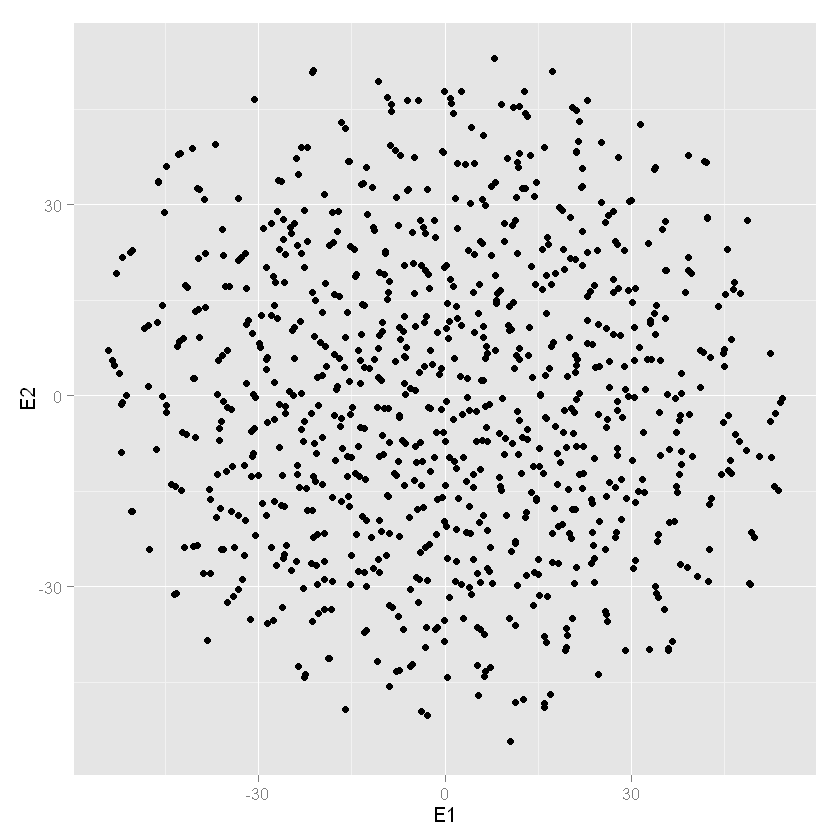

In [34]:
tsne_data <- tsne(apply(flog_rmdtc,2,rank), perplexity=20,epoch = 100)
tsne_embed_alt <- tsne_data
colnames(tsne_embed_alt) <- c('E1','E2')

df <- as.data.frame(cbind(flog_rmdtc,tsne_embed_alt))

p8 <- ggplot(df, aes(E1, E2)) + geom_point()

p8

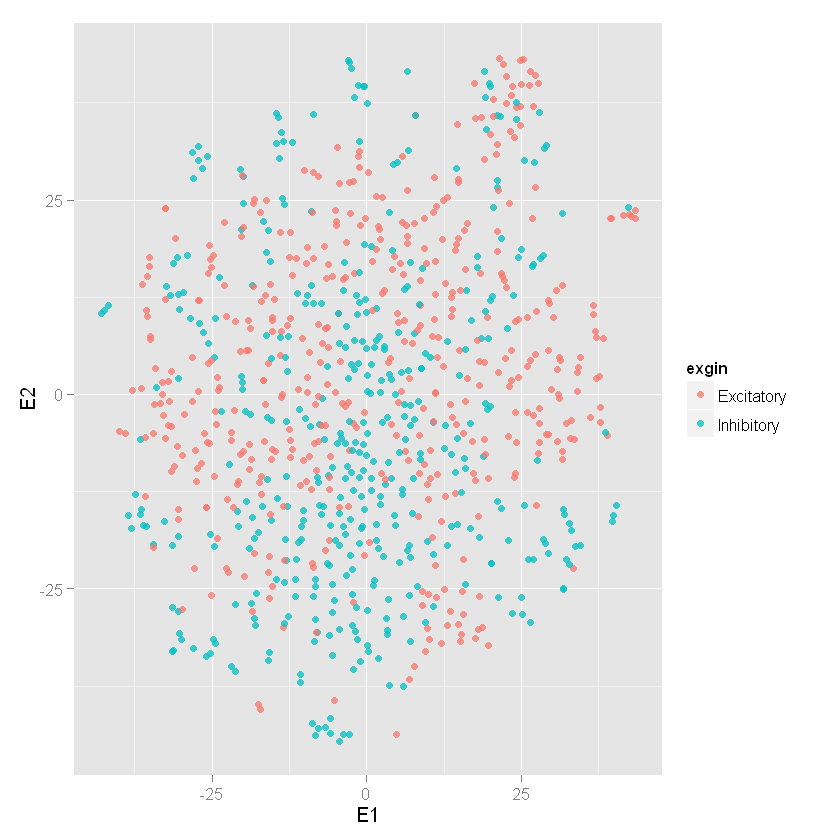

In [35]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.965 * ex_mean) > in_mean
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'


df <- as.data.frame(cbind(flog_rmdtc,tsne_embed))
df <- cbind(df,as.data.frame(exgin))

p7 <- ggplot(df, aes(E1, E2)) + geom_point(aes(color = exgin), alpha = 0.75)

p7

Now let's switch gears. From literature, we know that about 20-25% of the synapses are inhbitiory, while the rest are excitatory. Perhaps we can use this to make pseudo-class labels for our synapses. Hopefully the structure of the labels will reveal something about the structure of the data.

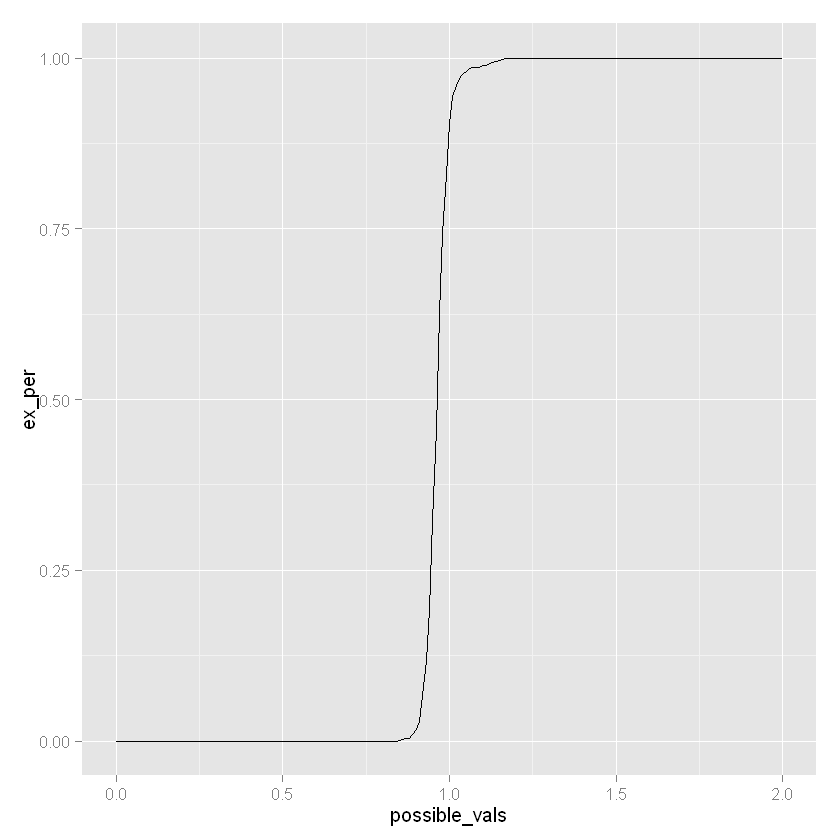

In [45]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

possible_vals <- seq(0,2,0.01)
ex_per<- c()

for (i in possible_vals){
    ex_per[round(i * 100 + 1)] <- sum((i * ex_mean) > in_mean) / length(ex_mean)
}
df <- as.data.frame(cbind(possible_vals,ex_per))

p8 <- ggplot(df,aes(possible_vals,ex_per)) + geom_line()

p8

The threshold to use to have 80% of synapse labels be excitatory is ~0.985.

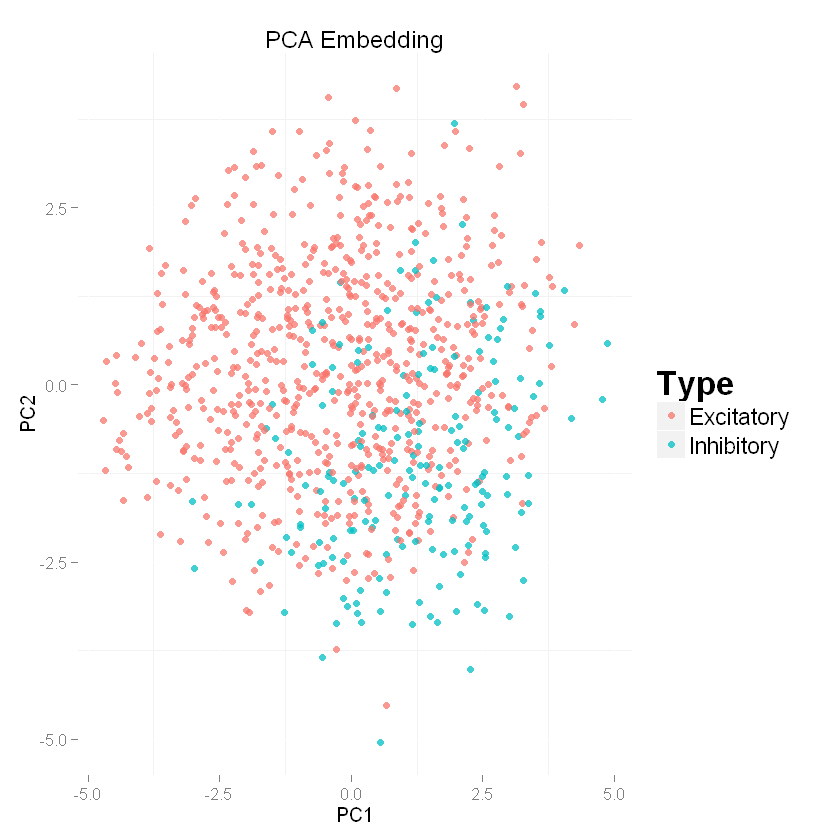

In [50]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.985 * ex_mean) > in_mean
exgin_n <- exgin
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'


fit_new <- prcomp(x = apply(flog_rmdtc,2,rank),center = TRUE,scale = TRUE)
data_embed_new <- fit_new$x[,1:2];

clust_graph <- as.data.frame(data_embed_new)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p9 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p9

Let's treat the marker intensities as gene expression levels and look at which genes are most differentially expressed relative to the class labels.

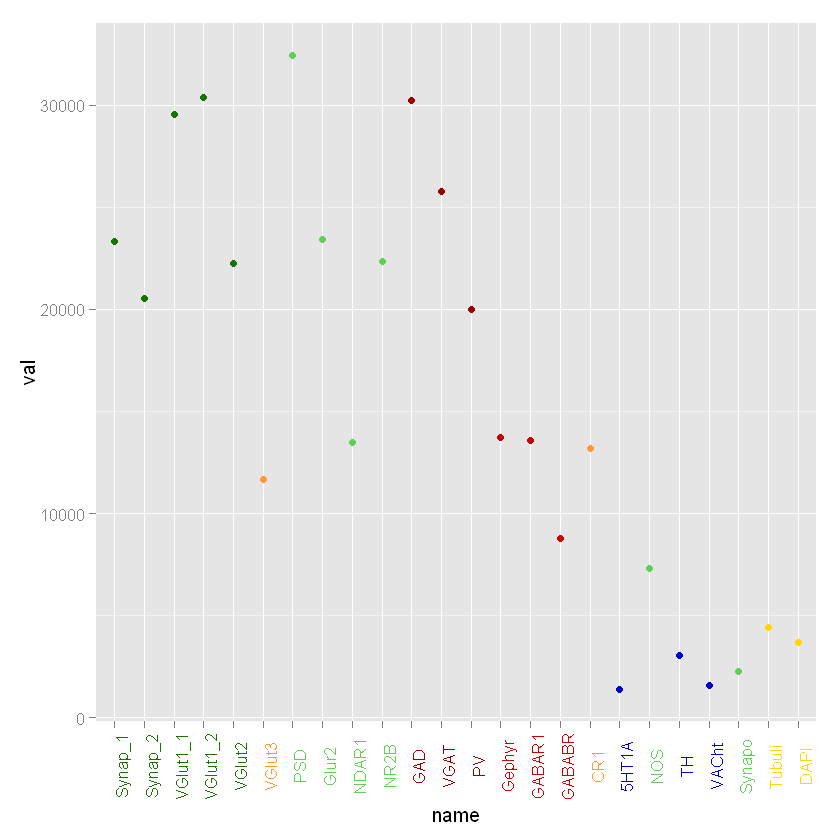

In [62]:
#Find Wilcoxon rank sums
N1 <- sum(exgin_n)
N0 <- length(exgin_n) - N1


ranks <- apply(flog_rmdtc, 2, rank, ties.method = "average")
rank_sums <- colSums(ranks[exgin_n == 1,])

#Compare to mean
mean_sum <- N1 * (N0 + N1 + 1) / 2

rank_sums_centered_abs <- abs(rank_sums - mean_sum)

df <- as.data.frame(rank_sums_centered_abs)
df <- cbind(as.data.frame(gsub('_Int_Bright','',colnames(flog_rmdtc))),df)
colnames(df) <- c('name','val')
df$name <- factor(df$name, levels=unique(as.character(df$name)) )

p10 <- ggplot(df,aes(name,val)) + geom_point(color = ccol) + theme(axis.text.x = element_text(angle = 90, color=ccol))

p10

It looks like NDAR1, 5HT1A, NOS, TH, VACht, Synapo, Tubuli, and DAPI are not differentially expressed for the exitatory/inhbitiory labels. Note that we express the excitaotry to show greater differentialy expression than the inhbitiory become 80% of the markers are excitatory. Let's remove these 8 (columns 9, 18, 19, 20, 21, 22, 23, 24).

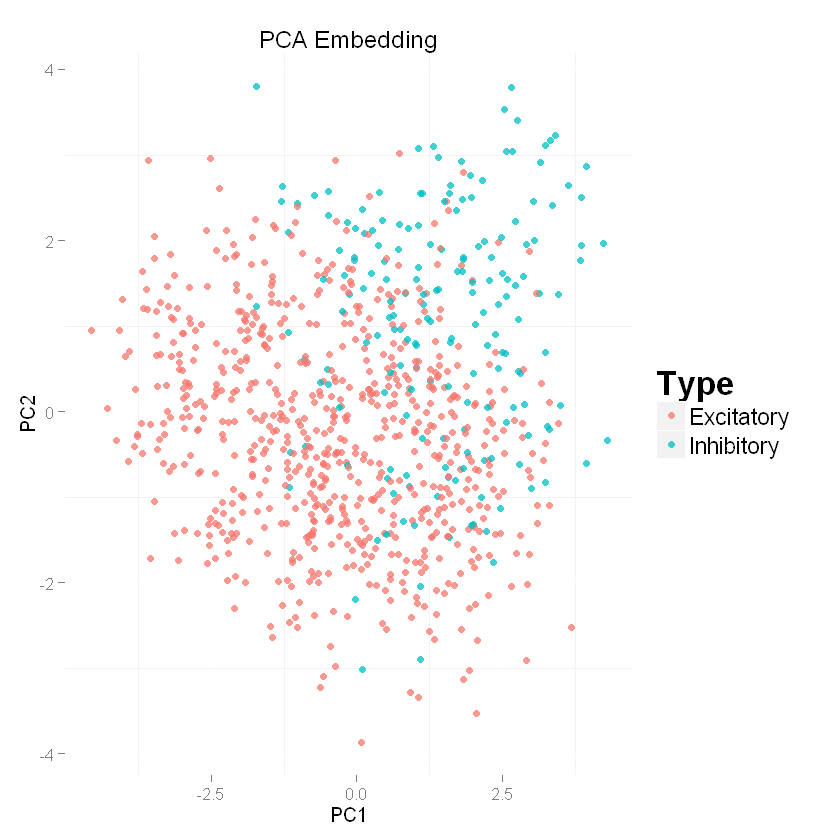

In [63]:
ex_mean <- rowMeans(flog_rmdtc[,c(1,2,3,4,5,7,8,9,10,19,23)])
in_mean <- rowMeans(flog_rmdtc[,c(6,11,12,13,14,15,16,17)])

exgin <- (0.985 * ex_mean) > in_mean
exgin_n <- exgin
index_true <- which(exgin == 1)
index_false <- which(exgin == 0)

exgin[index_true] <- 'Excitatory'
exgin[index_false] <- 'Inhibitory'


fit_new <- prcomp(x = apply(flog_rmdtc[,-c(9,18,19,20,21,22,23,24)],2,rank),center = TRUE,scale = TRUE)
data_embed_new <- fit_new$x[,1:2];

clust_graph <- as.data.frame(data_embed_new)
clust_graph <- cbind(clust_graph,as.data.frame(exgin))
colnames(clust_graph)[3] <- 'Type'
clust_graph[,3] <- as.factor(clust_graph[,3])

p10 <- ggplot(clust_graph,aes(PC1,PC2,color = Type)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p10

There is better separability now. Just for sake of interest, let's look at  5HT1A, TH, VACht only (columns 18, 20 ,21).

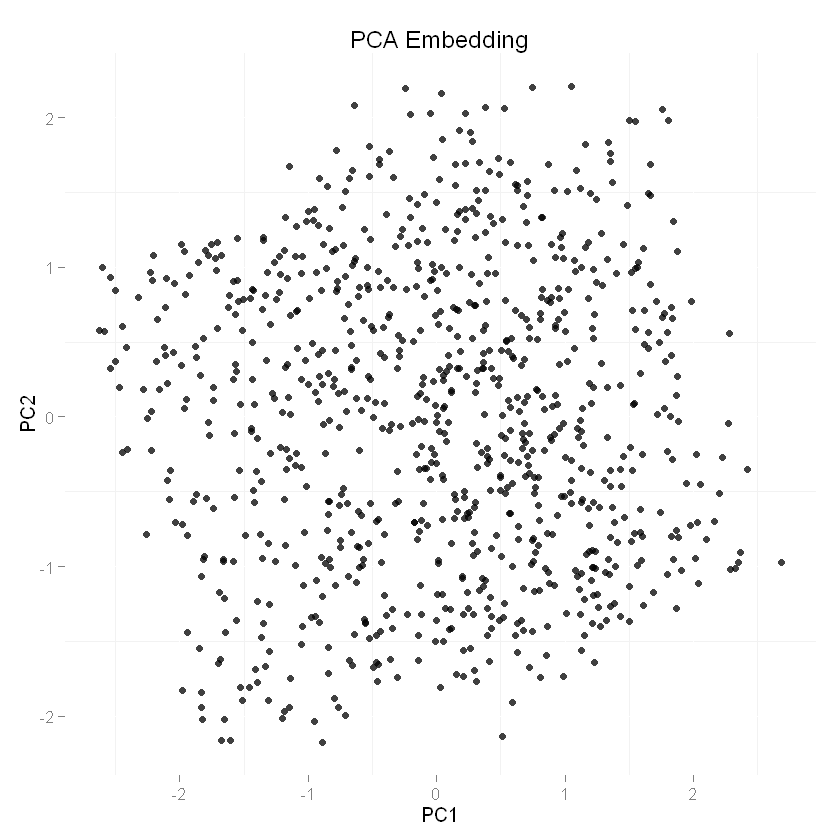

In [64]:
fit_new <- prcomp(x = apply(flog_rmdtc[,c(18,20,21)],2,rank),center = TRUE,scale = TRUE)
data_embed_new <- fit_new$x[,1:2];

clust_graph <- as.data.frame(data_embed_new)

p11 <- ggplot(clust_graph,aes(PC1,PC2,)) + geom_point(alpha = 0.75)  + 
theme(legend.text=element_text(size=14), legend.title = element_text(size = 20),panel.background = element_blank(), plot.background = element_blank()) + 
ggtitle('PCA Embedding')

p11

Doesn't look like there is too much there. Let's return to the excitatory/inhibitory marker. Let's also try generating labels for pre/post-synaptic excitoatory/inhibitory udner the assumption that 50% are pre-synaptoc and 50% are post-synaptic.